## 抓取地震数据并分析
### 1. 一点点地震小知识
#### 默默围观了一点地震知识，粗糙地为后面的分析做了个记录：
- 地震深度越浅，地震破坏越大
- 震级换算 ML = ( MS + 1.08 ) / 1.13     
    表格中有两种震级，Ml 和 Ms ，我国公布地震用 Ms 面波震级。    
    但是捏，尝试 Ml 换 Ms 以后，出现了负数。暂时没有查到负数 Ms 的处理方式，而且数据表中 Ms 的数据非常少，这里就粗糙地用 Ml 来表示震级咯。

### 2. 数据抓取
#### 尝试用 pandas 抓表格数据，粗线了 attrs 问题。降低 bs 版本以后，表抓出来了，但当时忘记选择表格5，用了 requests 来爬。
#### 注意 : **requests 抓下来的中文网页需要转码**  
res.encoding = 'gb18030'

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
res = requests.get("http://data.earthquake.cn/datashare/globeEarthquake_csn.html")
res.encoding = 'gb18030'
soup = bs(res.text)
tb = soup.select('table')[5]
date = [tr.select('td')[0].text for tr in tb.select('tr')]
time = [tr.select('td')[1].text for tr in tb.select('tr')]
lat = [tr.select('td')[2].text for tr in tb.select('tr')]
lon = [tr.select('td')[3].text for tr in tb.select('tr')]
depth = [tr.select('td')[4].text for tr in tb.select('tr')]
lvl = [tr.select('td')[5].text for tr in tb.select('tr')]
etype = [tr.select('td')[6].text for tr in tb.select('tr')]
place = [tr.select('td')[7].text for tr in tb.select('tr')]
edf = pd.DataFrame({'date': date[1::], 'time': time[1::], 'lon': lon[1::], 
                    'lat': lat[1::], 'depth':depth[1::], 'lvl':lvl[1::], 'etype':etype[1::], 'place':place[1::]})

edf.head()

,date,depth,etype,lat,lon,lvl,place,time
0,2016-05-26,6,天然地震,28.5,87.6,Ms3.2,西藏日喀则市定日县,17:29:25.1\n
1,2016-05-24,12,天然地震,27.46,101.81,ML2.4,四川盐源,23:57:15.8\n
2,2016-05-24,13,天然地震,27.48,101.82,ML2.4,四川盐源,23:57:15.7\n
3,2016-05-24,15,天然地震,37.46,115.01,ML1.3,河北宁晋,23:55:45.5\n
4,2016-05-24,10,天然地震,37.70,112.46,ML1.1,山西太原,23:53:56.0\n


### 3. 数据清理
#### 小结 : 留下了原表格中的7个数据，没有参考地震深度 
- 经纬度：画图描点定位
- 地点：查看发震率的省份排名  
- 时间：查看发震时间一般集中在哪个时点
- 事件类型：查看不同地震事件类型的分布情况    
- 深度与震级：深度越浅，地震破坏越大，负相关。而震级与破坏力度呈正相关，方便画图，于是用震级来实现地震图点大小。  

#### 清理地点数据
- 只看省份，留下前两个中文   

#### 清理经纬度、地震深度数据
- 转浮点数就好啦 (说不定以后会用到深度，先转了存 csv)

#### 清理震级数据
- 把震级数据中的字母剔除，转浮点数
- 换算 Ms 与 Ml 值

#### 清理时间数据
- 将时间转为datetime64标准格式  
用pandas自带的时间序列，可以按照时间先后对数据进行排序

In [9]:
# 清理地点数据
edf['place'] = edf['place'].map(lambda x : x[0:2])

# 清理经纬度、深度数据
edf[['lon','lat','depth']]=edf[['lon','lat','depth']].astype(float)

# 清理震级数据
idx = edf['lvl'][edf['lvl'].str.contains(r'Ms')].index
# 去除震级中的字母，也可以用edf['lvl'].map(lambda x: float(re.findall('\d+\.\d+', x)[0]))
lvl1 = pd.Series([float(filter(lambda ch: ch in '0123456789.', x)) for x in lvl[1::]])
# 带入Ms波面震级的索引数，换算成Ml，震级转化完成
lvl1[idx] = [round((x+1.08)/1.12,1) for x in lvl1[idx]]
edf['lvl_new'] = lvl1

# 清理时间数据，把时间转换成datetime64认可的形式
edf['time'] = edf['time'].map(lambda x : x[0:8])
edf['datetime'] = edf['date']+'T'+edf['time']

# 存入csv，数据中有中文，需要转码
edf.to_csv('earthquake.csv', encoding='utf-8')

edf.head()

,date,depth,etype,lat,lon,lvl,place,time,lvl_new,datetime
0,2016-05-26,6.0,天然地震,28.50,87.60,Ms3.2,西藏,17:29:25,3.8,2016-05-26T17:29:25
1,2016-05-24,12.0,天然地震,27.46,101.81,ML2.4,四川,23:57:15,2.4,2016-05-24T23:57:15
2,2016-05-24,13.0,天然地震,27.48,101.82,ML2.4,四川,23:57:15,2.4,2016-05-24T23:57:15
3,2016-05-24,15.0,天然地震,37.46,115.01,ML1.3,河北,23:55:45,1.3,2016-05-24T23:55:45
4,2016-05-24,10.0,天然地震,37.70,112.46,ML1.1,山西,23:53:56,1.1,2016-05-24T23:53:56


### 4. 分省份地震频数图
#### 思路：
1. 利用pandas中df[column].value_counts()特性，倒序排列地震频数
2. 抽取地震频数最多的15个省份，画柱状图    
∵ 地震数据覆盖的时间很短，且处在板块交界处的省份集中在西部   
∴ 排名靠后的省份数据量太少，也就不作分析了

#### 遇到的问题
- 问题1：中文标签显示问题  
替换matplotlib字体解决
- 问题2：末尾省份频率较小，默认的y轴100间隔不够详细  
用MultipleLocator设置间隔为50

#### 可视化结果
- 在5月20日到5月26日之内，云南省地震数最高，四川省其次，新疆省再次。   
- 这三个省份的地震频数都超过了100次，其中四川省地震频数达到了500次。      
- 其他处在地震频数前15的省份为：西藏，甘肃，山西，青海，广东，河北，辽宁，福建，内蒙，北京，河南，陕西。

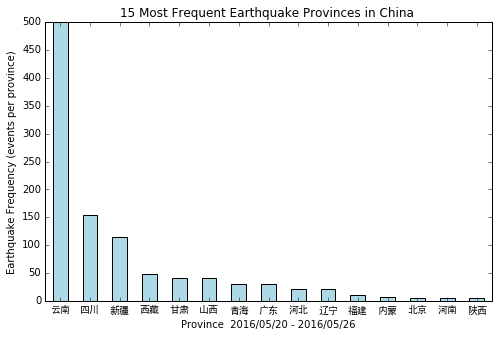

In [8]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
font = FontProperties(fname=r"/Library/Fonts/simhei.ttf") 

plt.figure(figsize=(8,5))

eq_descending = edf['place'].value_counts()
ax = eq_descending[0:15].plot(kind='bar', rot=0, color='lightblue')

# 设置标签字体
for label in ax.get_xticklabels(): 
    label.set_fontproperties(font) 
    
ax.set_xlabel('Province  2016/05/20 - 2016/05/26')
ax.set_ylabel('Earthquake Frequency (events per province)')
ax.set_title('15 Most Frequent Earthquake Provinces in China ')

ymajorLocator   = MultipleLocator(50)
ax.yaxis.set_major_locator(ymajorLocator) 

#### 发震频数表格

In [5]:
eq_form = pd.DataFrame(eq_descending, eq_descending.index)[0:15].transpose()
eq_form.index = ['地震次数']
eq_form

,云南,四川,新疆,西藏,甘肃,山西,青海,广东,河北,辽宁,福建,内蒙,北京,河南,陕西
地震次数,500,154,114,49,42,41,30,30,22,21,10,7,6,5,5


### 5. 地震数据 - 地图可视化
#### 思路
- 用basemap来实现地图可视化
- 设置画图用的经度(lon)、纬度(lat)、图点大小(lvl)  
这里x,y不能像size一样直接从DataFrame的列当中读取数据，x1和y1取值用到了basemap函数，不支持array读取
- 查看人为爆破数据，根据不同事件类型进行标注

#### 遇到的问题：
- 刚开始，evt由for循环构建，导致x[evt[0]]不能读取， 显示IndexError: invalid index to scalar variable
解决：把构成evt的index数据直接转成list
http://stackoverflow.com/questions/26757936/indexerror-invalid-index-to-scalar-variable

#### 可视化结果：
- 地震地点主要集中在西南板块交界处、西北边域及北纬37度附近地区

In [42]:
edf['etype'][edf['etype'].str.contains(u'爆')]

621    疑爆
958    爆破
Name: etype, dtype: object

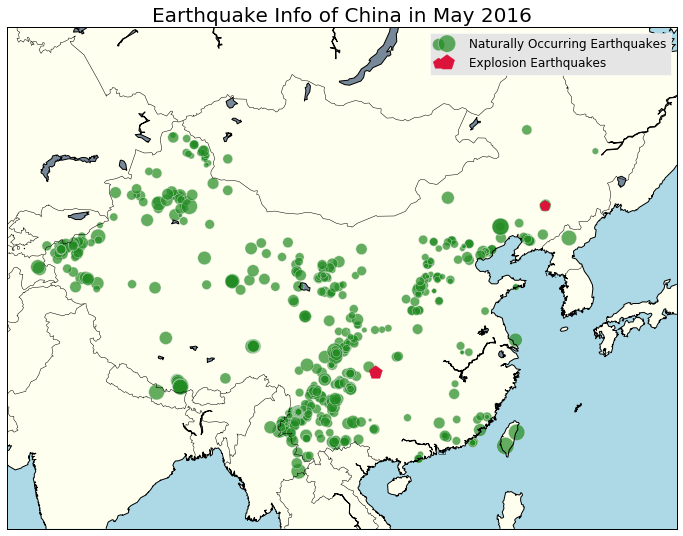

In [74]:
%matplotlib inline 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

map = Basemap(
        projection='merc', llcrnrlon=70, llcrnrlat=15,
        urcrnrlon=138, urcrnrlat=55, lat_0=15, lon_0=95, resolution='l')

x = list(edf['lon'])
y = list(edf['lat'])
size = edf['lvl_new']
x1,y1=map(x,y)

# 两例爆破地震
evt = list(edf['etype'][edf['etype'].str.contains(u'爆')].index)
xx = [x[evt[0]], x[evt[1]]]
yy = [y[evt[0]], y[evt[1]]]
x2, y2 = map(xx, yy)

map.drawmapboundary(fill_color='lightblue')
map.drawcountries()
map.drawcoastlines()
# 如不设置zorder=0，画图内容将无法显示
map.fillcontinents(color='ivory',lake_color='lightslategrey',zorder=0)
map.scatter(x1, y1, s=size*60,c='forestgreen',marker="o", alpha=0.7, label= 'Naturally Occurring Earthquakes')
map.scatter(x2, y2, s=size*50, color='crimson', marker="p", label= 'Explosion Earthquakes')
plt.title("Earthquake Info of China in May 2016", size=20)

plt.legend()
plt.show()


### 6. 地震发生时间分析
#### 思路：
1. 获取每小时地震发生频数
2. 依据各小时地震频数画柱状图

#### 实现方法
见代码

#### 数据分析结果：
在5月20日至5月26日之间，凌晨3点左右与傍晚6点到7点为地震高发期。

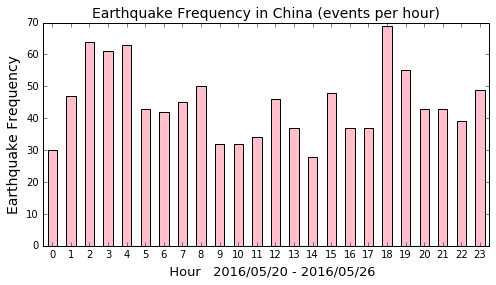

In [7]:
%matplotlib inline 
# 时间数据清理。这里需要把x轴固定为24小时，因此把日期固定在某一天
edf1 = edf
edf1['time'] = edf['time'].map(lambda x : x[0:2])
edf1['datetime'] = edf['date'][0]+'T'+edf1['time']

# 对各小时地震发生次数进行倒序排序
get_counted  = edf1['datetime'].value_counts()

# 把序列的数据类型转为datetime形式，以便后面排序
get_counted.index.astype('datetime64[s]')

# 用df.sort_index()排序
get_counted = get_counted.sort_index()

# 序列名太长，不利于画图：把index转为简洁的24小时数字
get_counted.index=[range(24)]

# 画柱状图：x轴表示的数值相互独立时，用柱状图表示
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
ax = get_counted.plot(kind='bar', rot=0, color = 'pink')
ax.set_xlabel('   Hour   2016/05/20 - 2016/05/26', size=13)
ax.set_ylabel('Earthquake Frequency', size=14)
ax.set_title('Earthquake Frequency in China (events per hour)',  size=14)

In [6]:
pd.set_option('display.max_columns', 25)
get_counted2  = edf1['time'].value_counts()
hour_form = pd.DataFrame(get_counted2, get_counted2.index)
hour_form.columns = ['地震次数']
hour_form.transpose()

,18,02,04,03,19,08,23,15,01,12,07,21,05,20,06,22,16,17,13,11,10,09,00,14
地震次数,69,64,63,61,55,50,49,48,47,46,45,43,43,43,42,39,37,37,37,34,32,32,30,28
